# Impact of Barren Plateaus Mitigation Strategy on the Performance of Quantum Neural Networks
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (MNIST)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen

**Date:**
- June 2023

**Data:**
- Data = IRIS dataset with 99 examples
- Features = 4
- Target = {-1, 1}
- Iterations = 120
- Instance = 10

**Description:**
- This notebook aims to train 10 instances of a QNN initialised with identity blocks and produce averaged performance stats

In [1]:
import copy, math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, X, I, StateFn, PauliExpectation, Gradient, NaturalGradient, PauliSumOp
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, OpflowQNN, CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
# algorithm_globals.random_seed = 42

from IPython.display import clear_output

In [2]:
from Components.circuits import preTrainedBlockGenerator, layerwise_training, featureMapGenerator, AnsatzGenerator
from Components.data import iris, fetch_mnist, fetch_mnist_balanced
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results
from Components.train import create_qnn, sampling_experiment, train, train_batch

In [3]:
DATA_SIZE = 500
FEATURE_DIM = 4
MAX_ITER = 120
MAX_INST = 10

MAX_REPS = 9
MIN_REPS = 1
MAX_IDENTITIES_BLOCKS = 2  # <---- Number of identity blocks, depth values of identity blocks is close to that of normal ansatz (5 qubits)
ENTANGLEMENT = 'linear'

GLOBAL_OPERATOR = PauliSumOp.from_list([('Z'*FEATURE_DIM, 1)])
LOCAL_OPERATOR = PauliSumOp.from_list([('I' * (FEATURE_DIM - 2)+'Z'*2, 1)])

LOG_PATH = './Logs-MNIST-v4'
METHOD_TAG = 'm1'

In [4]:
X_train, X_val, y_train, y_val = fetch_mnist_balanced(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

/home/jacob/miniconda3/envs/qiskit/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Training set: 350 samples
Testing set: 150 samples
Number of features: 4
Classes:[0 1]; Encoded as: [-1  1]


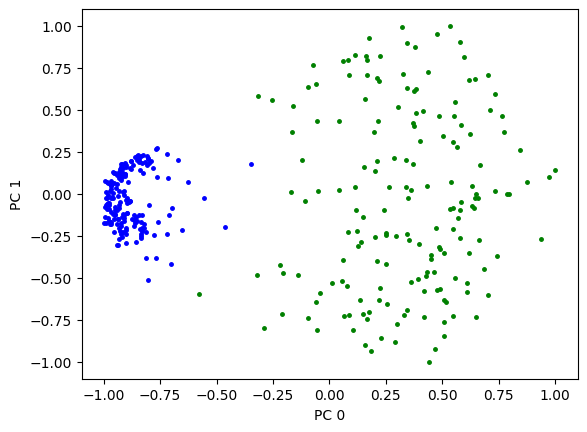

Blue: torch.Size([175])
Green: torch.Size([175])


In [5]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

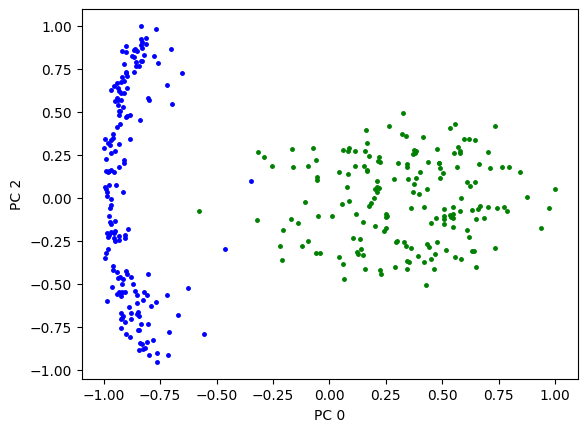

Blue: torch.Size([175])
Green: torch.Size([175])


In [6]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [7]:
def plot_method_data(data, title='Instance Losses', dlabel='inst#', xlabel='Loss', ylabel='Iteration'):
    # create figure and axis
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(8)
    
    # setting the axis' labels
    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    
    # Plot data
    for i in range(len(data)):
        data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
    ax.legend([f'{dlabel} {i}' for i in range(len(data))])
    plt.title(title)
    plt.show()  

## Method 1 (Local Loss and Shallow Ansatz)

In [8]:
from qiskit.primitives import Estimator # Statevector estimator
from os.path import exists
from os import makedirs

In [9]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(FEATURE_DIM, reps=MIN_REPS, entanglement=ENTANGLEMENT)
qc = feature_map.compose(ansatz)

In [10]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [0]: 
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')
        
    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=LOCAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    # initial weights are chosen uniformly at random from [-1, 1]
    model = TorchConnector(qnn)

    loss_function = nn.L1Loss() # nn.MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )

    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)

Creating the first instance 0 of method m1

Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      1.0318800210952759   0.36571          0.33333         
[ 10 ]     0.9731400012969971   0.56             0.52            
[ 20 ]     0.9402999877929688   0.65143          0.6             
[ 30 ]     0.8832399845123291   0.66857          0.68667         
[ 40 ]     0.8410999774932861   0.76             0.8             
[ 50 ]     0.8326500058174133   0.74571          0.84667         
[ 60 ]     0.8324900269508362   0.75429          0.84            
[ 70 ]     0.8324699997901917   0.75143          0.83333         
[ 80 ]     0.8324099779129028   0.74857          0.84            
[ 90 ]     0.8324000239372253   0.74857          0.84            
[ 100 ]    0.8324000239372253   0.74857          0.84            
[ 110 ]    0.8324000239372253   0.74857          0.84            
[ 119 ]    0.8324000239372253   0.74857          0.84            


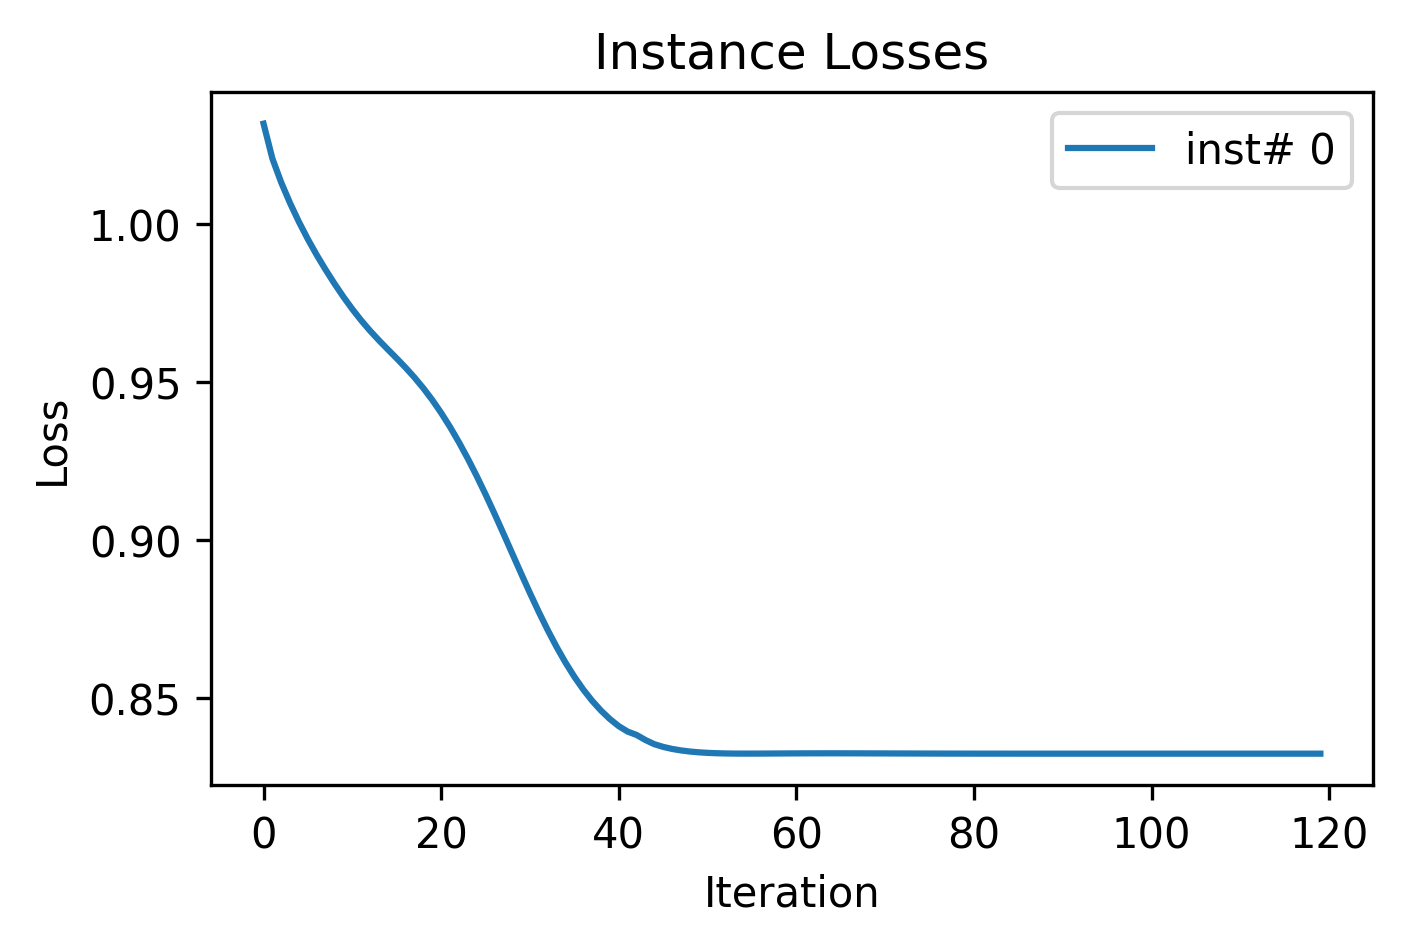

In [11]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

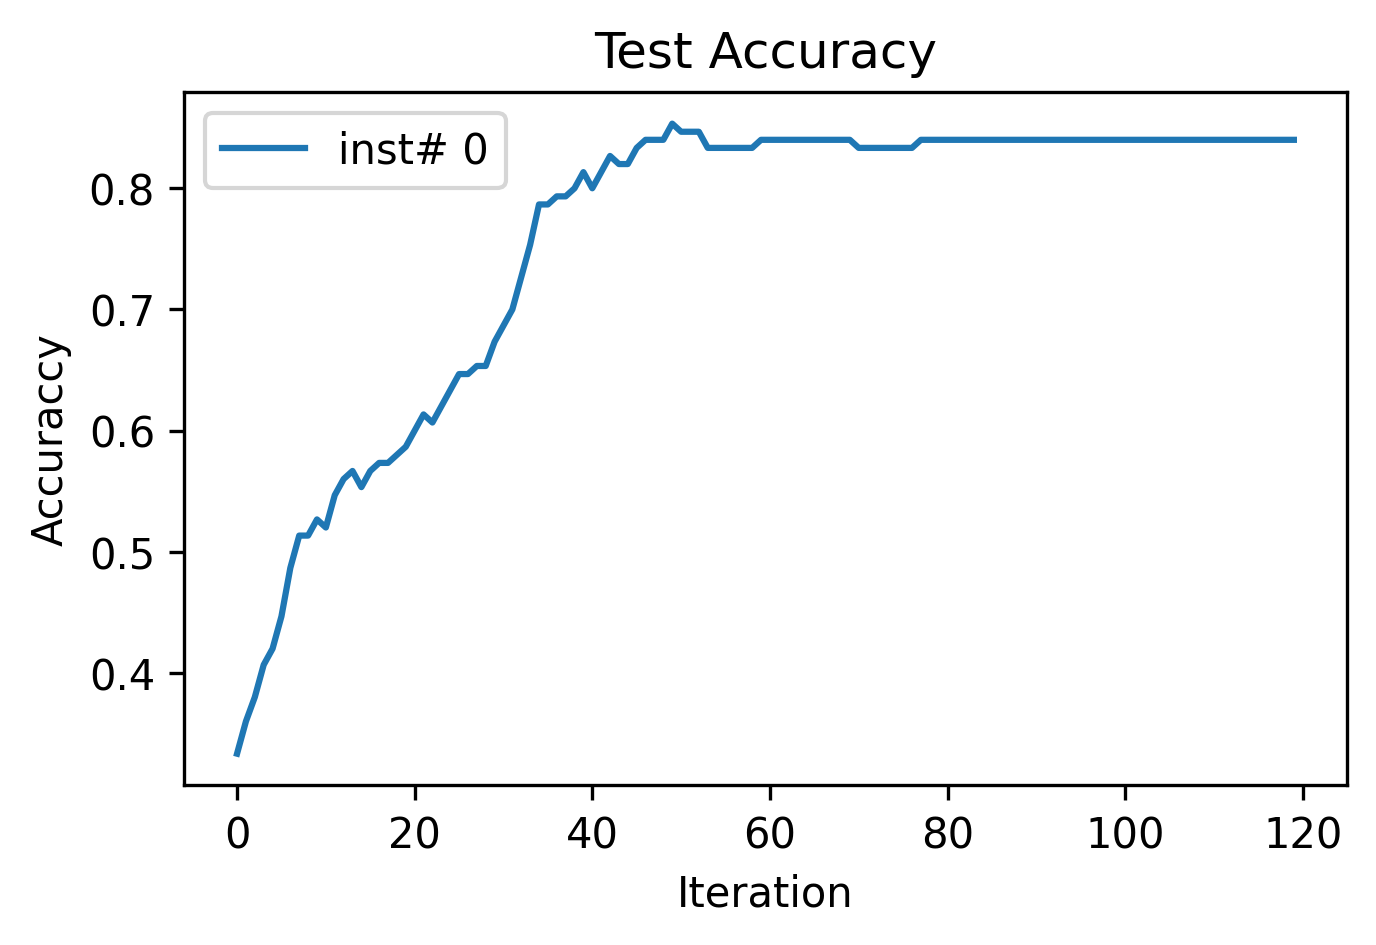

In [12]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [13]:
!pip list | grep qiskit

qiskit                        0.41.0
qiskit-aer                    0.11.2
qiskit-experiments            0.4.0
qiskit-finance                0.3.4
qiskit-ibm-experiment         0.2.8
qiskit-ibm-provider           0.2.1
qiskit-ibm-runtime            0.8.0
qiskit-ibmq-provider          0.20.0
qiskit-machine-learning       0.5.0
qiskit-nature                 0.5.2
qiskit-optimization           0.5.0
qiskit-terra                  0.23.1


In [14]:
!pip list | grep torch

torch                         1.13.1
torchaudio                    0.13.1
torchsummary                  1.5.1
torchvision                   0.14.1
